# Homework 3 Part 2 Task 3 - Cross-validation
This taks is similar to task 2, you will build regressors to Predict House Prices <br>
Here is the difference: we will use cross-validation to find the best hyper-parameters <br>
If the dataset is relatively small, cross-validation may lead to a better estimation <br>
Since we are in the 'big-data' and 'cloud-data' era, a one-time trainig-validation-testing split is just fine. <br>
However, you should do this task in case that your future boss gives you a small dataset and wants some results. <br>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the training and testing datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [4]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)
show the missing values for each feature

In [5]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,8,16
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<AxesSubplot:>

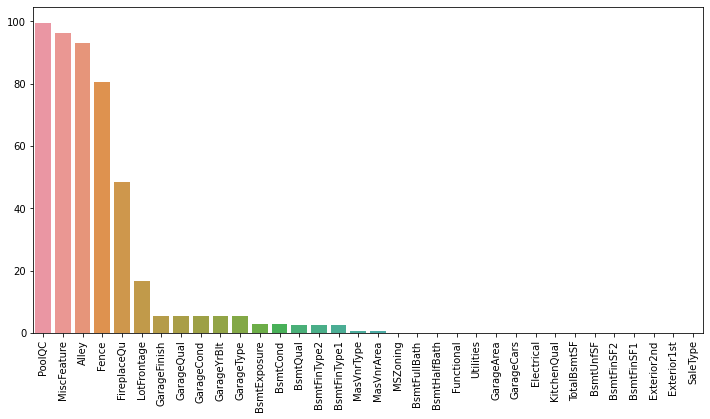

In [6]:
#show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=data_missing.index, y=data_missing)

From the figure, we see that nearly 100% values of the feature/column 'PoolQC' are missing <br>
We can simply delete these features (drop these columns from the table) of which >=50% values are missing

In [7]:
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

In [8]:
#drop the columns
data=data.drop(columns=feature_drop)
#drop Id
data=data.drop(columns='Id')

In [9]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


For those features with < 50% missing values, we can use impute method. <br>
Missing numerical values can be imputed with a constant value, or some statistics (mean, median or most frequent) of each column in which the missing values are located. <br>
Missing categorical/non-numeric values can be imputed with the most frequent category, or a new category-'nothing'

In [10]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        #data[c]=data[c].fillna(v.value_counts().index[0]) # the most frequent category
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [11]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding <br>
note: there are other methods to encode categorical values

In [12]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 296)

In [13]:
#the table has many new columns
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,0,1,0


### get training data and testing data from `data`

In [14]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [15]:
X_train.dtype

dtype('float64')

In [16]:
X_train.shape

(1460, 294)

In [17]:
Y_train.dtype

dtype('float64')

In [18]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

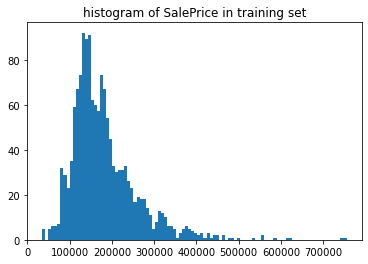

In [19]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

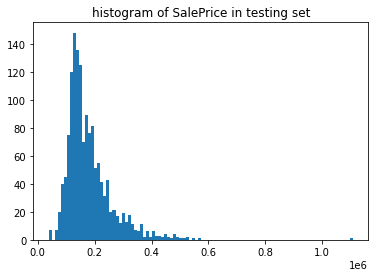

In [20]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

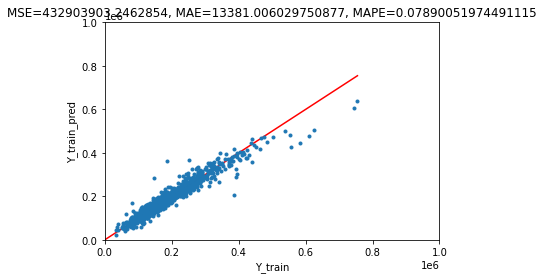

In [22]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

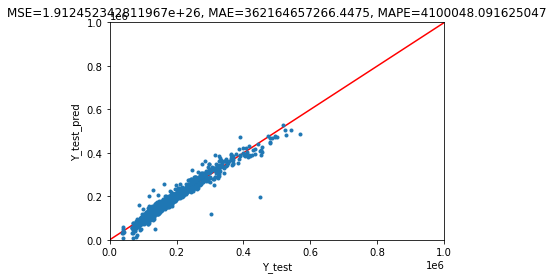

In [23]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [24]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

310

Perform 10-fold cross valiation to get the average MAPE (or other accuracy measurements)

In [25]:
#attention: if you choose to use GridSearchCV
#           it assumes a better model has a higher score
#           thus, my_scorer should return -MAPE as the score of the model
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE
#
from sklearn.model_selection import cross_val_score
MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([1.11110523e-01, 6.63536491e+02, 1.07969484e-01, 1.21082785e-01,
       1.20892225e-01, 1.06199299e-01, 1.07316473e-01, 4.33483587e+00,
       3.16418138e+01, 9.37846418e-02])

Linear regression seems to be fine except for a few testing data points <br>
Next, let's try nonlinear regression models and see if we can get better results

## Your task begins here
### Predict SalePrice using nonlinear regression models
Try the two types of models <br>
(1) KNN (hyperparameter is `n_neighbors`) <br>
(2) random forest <br>
&nbsp;&nbsp;&nbsp; It has many hyperparameters. <br>
&nbsp;&nbsp;&nbsp; You can just focus on `max_depth`, and set `n_estimators` to 100 <br>

For model selection (i.e. to determine the hyperparameters), we apply cross-validation to get the average MAPE (or other measurements) on the validation sets. Try different sets of hyperparameters, and find the best hyperparameters associated with the minimum average MAPE. <br>
A simple strategy is grid search, which you will use to find the optimal hyperparameters. <br>
You may use the function `GridSearchCV` in https://scikit-learn.org/stable/modules/grid_search.html <br>
or write a for loop to do grid search, like this 
```python
MAPE_average_list=[]
hyperparameter_list=[1, 2, 3, 4, 5]
for hyperparameter in hyperparameter_list:
    my_model=SomeRegressor(hyperparameter) # set random_state=0 if possible
    MAPE_array = cross_val_score(my_model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
MAPE_average_list=np.array(MAPE_average_list)
#hyperparameter_best = hyperparameter_list[np.argmin(MAPE_average_list)]
#or hyperparameter_best is the point at which the curve hyperparameter~MAPE becomes flat 
plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE')  
```    
`cross_val_score` is imported from sk-learn <br>
note: set 'n_jobs=4' to use multiple (4) cpu cores <br>
After the best hyperparameter is found, fit the model (using the best hyperparameter) to the whole training set, <br> 
and evaluate the model on the testing set (`X_test`, `Y_test`) to get MSE, MAE and MAPE  <br>
Do not use MSE/MAE/MAPE on the testing set for tuning hyperparameters, which will be 'cheating' <br>

Plot `hyperparameter` vs `MAPE` <br>
Plot `Y_train` vs `Y_train_pred`  <br>
Plot `Y_test` vs `Y_test_pred`  <br>
Show the values of MSE, MAE and MAPE on the traning set and the testing set <br>

#### KNeighborsRegressor

Text(0, 0.5, 'MAPE')

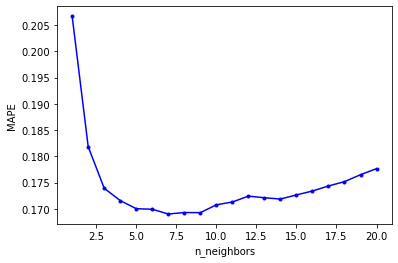

In [33]:
from sklearn.neighbors import KNeighborsRegressor
#use a for loop to do 10-fold cross-valiation to find the best n_neighbors
MAPE_average_list = []

n_neighbors = range(1, 21)

for n in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    MAPE_array = cross_val_score(knn, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
    
MAPE_average_list=np.array(MAPE_average_list)
    
plt.plot(n_neighbors, MAPE_average_list, '.-b')
plt.xlabel('n_neighbors')
plt.ylabel('MAPE')


In [35]:
#plot and find the best n_neighbors
best_n = n_neighbors[np.argmin(MAPE_average_list)]
best_n


7

build a KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

In [36]:
knn = KNeighborsRegressor(n_neighbors= best_n)
knn.fit(X_train, Y_train)
Y_train_pred = knn.predict(X_train)
Y_test_pred = knn.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

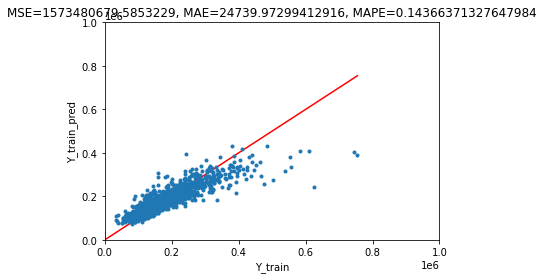

In [37]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

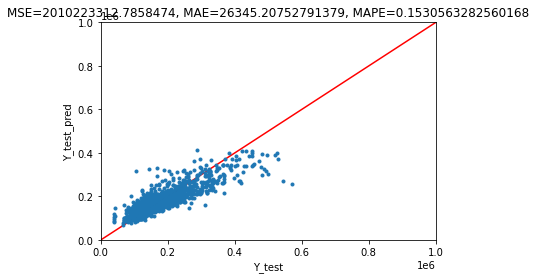

In [38]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

#### RandomForestRegressor

In [42]:
from sklearn.ensemble import RandomForestRegressor
#use a for loop to do 10-fold cross-valiation to find the best max_depth

MAPE_average_list = []
max_depth_list = range(1, 101, 5)

for max_depth in max_depth_list:
    RFR = RandomForestRegressor(max_depth=max_depth, n_estimators=100)
    MAPE_array = cross_val_score(RFR, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
    print(max_depth)


1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


Text(0, 0.5, 'MAPE')

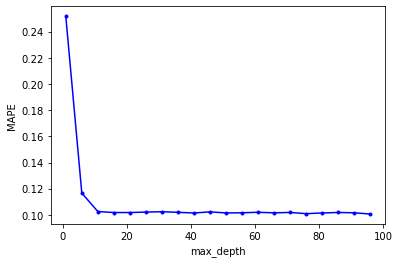

In [43]:
MAPE_average_list=np.array(MAPE_average_list)
    
plt.plot(max_depth_list, MAPE_average_list, '.-b')
plt.xlabel('max_depth')
plt.ylabel('MAPE')

In [44]:
#plot and find the best max_depth
best_depth = max_depth_list[np.argmin(MAPE_average_list)]
best_depth

96

build a RandomForestRegressor using the best hyperparameter <br> 
fit it to the training data and test it on the testing data

In [45]:
RFR = RandomForestRegressor(max_depth= best_depth, n_estimators=100)

RFR.fit(X_train, Y_train)
Y_train_pred = knn.predict(X_train)
Y_test_pred = knn.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

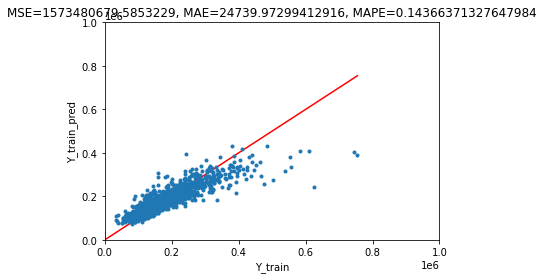

In [46]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

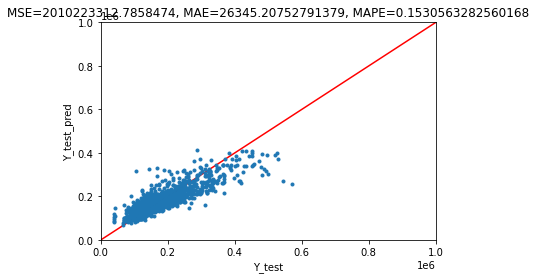

In [47]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

#### XGBRegressor
https://anaconda.org/anaconda/py-xgboost

In [58]:
max_depth_list = list(range(1, 10))+list(range(10, 101, 10))  


In [63]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
#try to use GridSearchCV to do 10-fold cross-valiation to find the best max_depth
#set random_state=0, objective='reg:squarederror'
#read the comments in the cell of "my_scorer", or you can use the "built-in" scorer in sk-learn

xgb = XGBRegressor(random_state=0)
parameters = {
              'objective': ['reg:squarederror'],
              'max_depth' : max_depth_list
              }

xgb_grid = GridSearchCV(xgb, parameters, cv = 10)
xgb_grid.fit(X_train, Y_train)


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [ ]:
#plot and find the best max_depth
def my_scorer_1(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y) * (-1)
    return MAPE

MAPE_array_list = cross_val_score(xgb_grid, X_train, Y_train, cv=10, scoring=my_scorer_1)


In [ ]:
best_depth = max_depth_list[np.argmin(MAPE_average_list)]

build a XGBRegressor using the best hyperparameter and fit it to the training data

In [38]:
xgb = XGBRegressor(random_state=0, max_depth = best_depth)

RFR.fit(X_train, Y_train)
Y_train_pred = knn.predict(X_train)
Y_test_pred = knn.predict(X_test)

show the training result

[0, 1000000.0, 0, 1000000.0]

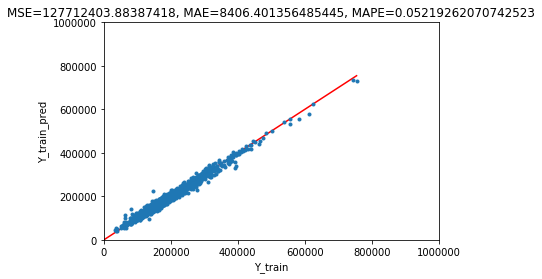

In [39]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

[0, 1000000.0, 0, 1000000.0]

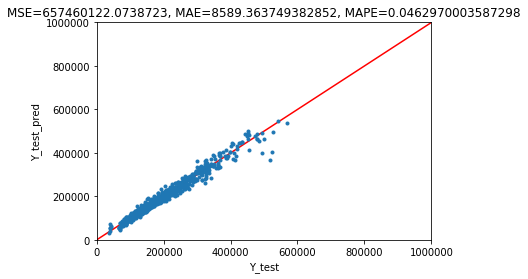

In [40]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [41]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

133

In this task, linear model is as good as nonlinear models <br>